Caffe: Optimizing Images Toward Labels
===
To explore the range of images our neural network associates with each label, we perform gradient ascent on seed images (similar to Google's Deep Dream) in order to move them closer to specified labels. In the process, we can infer something about how our network actually "perceives" or imagines digits.

In [1]:
import os
#os.chdir('/usr/lib/caffe')

In [2]:
import sys
sys.path.insert(0, '/usr/lib/caffe/python')
import caffe

from pylab import *
%matplotlib inline

In [3]:
rcParams['image.cmap']=u'gray'
rcParams['image.interpolation']=u'none'

In [4]:
caffe.set_device(0)
caffe.set_mode_cpu()

In [5]:
# Load the pretrained, deployed network from file
net = caffe.Net('/home/wiley/Desktop/Thesis/Work/deploy.prototxt',
                '/home/wiley/Desktop/Thesis/Work/lenet.caffemodel',
                caffe.TEST)

In [3]:
import pickle

In [4]:
f = open('/home/wiley/Desktop/Thesis/mnist/mnist.pkl')
mnist = pickle.load(f)
f.close()

IOError: [Errno 2] No such file or directory: '/home/wiley/Desktop/Thesis/mnist/mnist.pkl'

In [8]:
trn_img,trn_lbl = mnist[0]
tst_img,tst_lbl = mnist[1]
cvd_img,cvd_lbl = mnist[2]

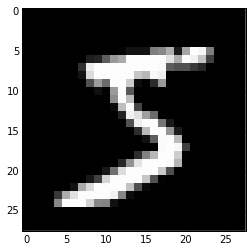

In [9]:
imshow(trn_img[0].reshape(28,28))

As before, we will be using the MNIST dataset and LeNet-based classifier.

---
We are looking to minimize the error between prediction-layer activations and a specified prediction. To perform gradient ascent, we will use the following loop:
 * Feedforward from an input image to get predictions
 * Multiply prediction vector with specified reference vector
 * Set gradient of the final layer equal to this
 * Compute error gradients for image layer via backpropagation
 * Move image along gradient

In [10]:
def backtrack(net,img_in,refGrad,k,learnRate):
    
    net.blobs['data'].data[0] = img_in.reshape(1,28,28)
    
    for i in range(k):
        # Feed forward
        net.forward()
        
        # Set the gradient at the final layer
        net.blobs['pred'].diff[0] = refGrad * net.blobs['pred'].data[0]
        
        # Backpropagate from here
        net.backward(start='pred')
        
        # Adjust image based on that
        net.blobs['data'].data[0] += net.blobs['data'].diff[0]*learnRate
        
        # Clamp to [0,1] range to respect max/min pixel intensities
        net.blobs['data'].data[0] = np.clip(net.blobs['data'].data[0],0,1)
    #imshow(net.blobs['data'].data[0,0])

In [11]:
# Construct a 10-dimensional vector whose elements are equal to fg at the
# specified index and bg elsewhere.
def makeRefGrad(label,bg,fg):
    v = np.zeros([10])+bg
    v[label] = fg
    return v

For easy visualization, the next function accepts an input image and optimizes it for each of the ten digit labels according to the supplied parameters.

In [13]:
def tableau(net,img,bg_val,fg_val,num_iter):
    figure(figsize=(4,4,))
    imshow(img.reshape(28,28))
    
    results = np.zeros([10,28,28])
    predVals = np.zeros([10,10])
    for i in range(10):
        backtrack(net,img,makeRefGrad(i,bg_val,fg_val),num_iter,100)
        results[i] = net.blobs['data'].data[0,0]
        predVals[i] = net.forward()['pred'][0]
    
    figure(figsize=(20,15))
    for i in range(10):
        if i < 5:
            j=i+1
        else:
            j=i+6
        subplot(4,5,j)
        imshow(results[i])
        subplot(4,5,j+5)
        bar(range(10),predVals[i])

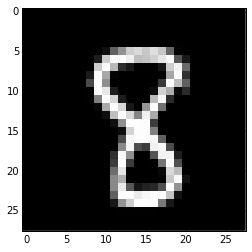

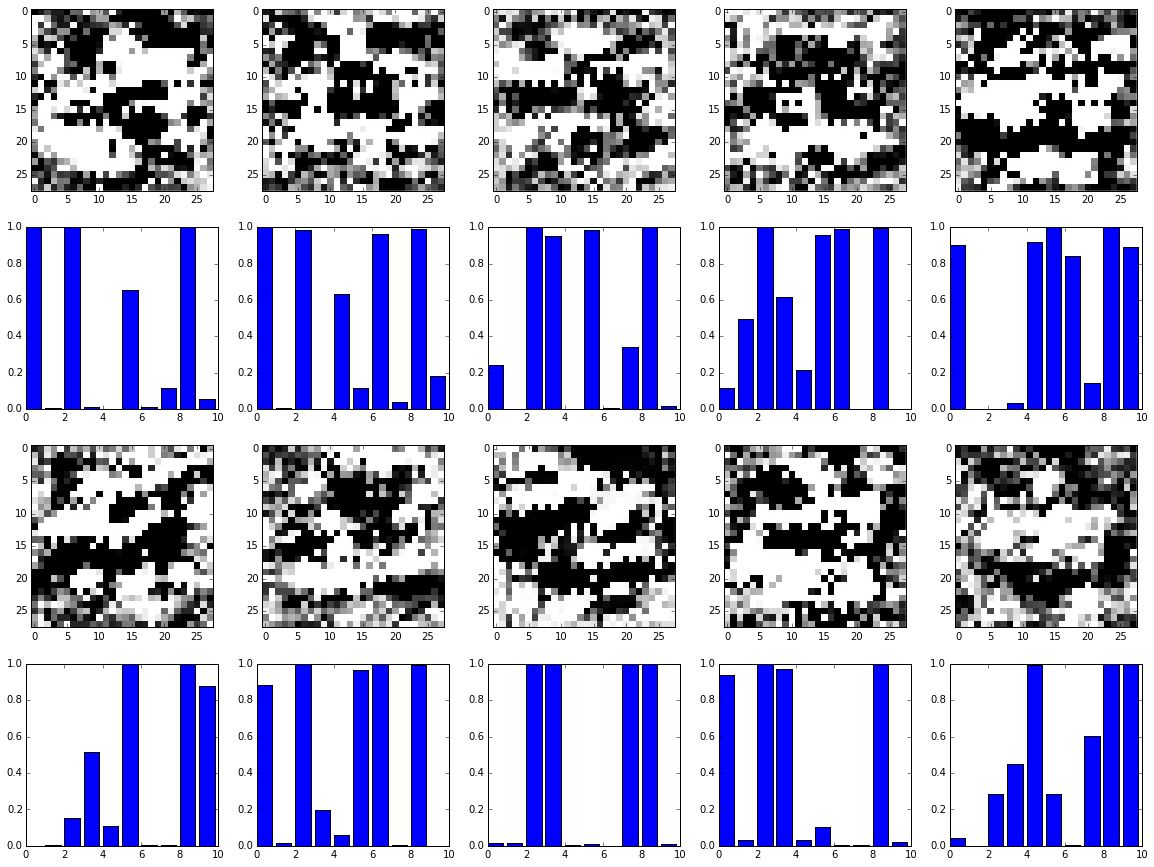

In [14]:
tableau(net,tst_img[1].reshape(1,28,28),-1,1,5000)

The bar charts under each optimized image indicate the prediction-layer activations of the neural network for each image.

Note that most of the optimized images retained a strong classification for the original image label (8), in addition to the new label.

The images are strongly characterized, but are not easily recognizable as Arabic numerals.

---
Are the results still as clear-cut if we start from a random image?

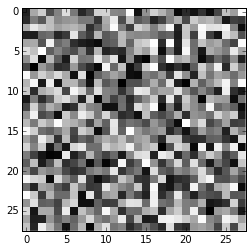

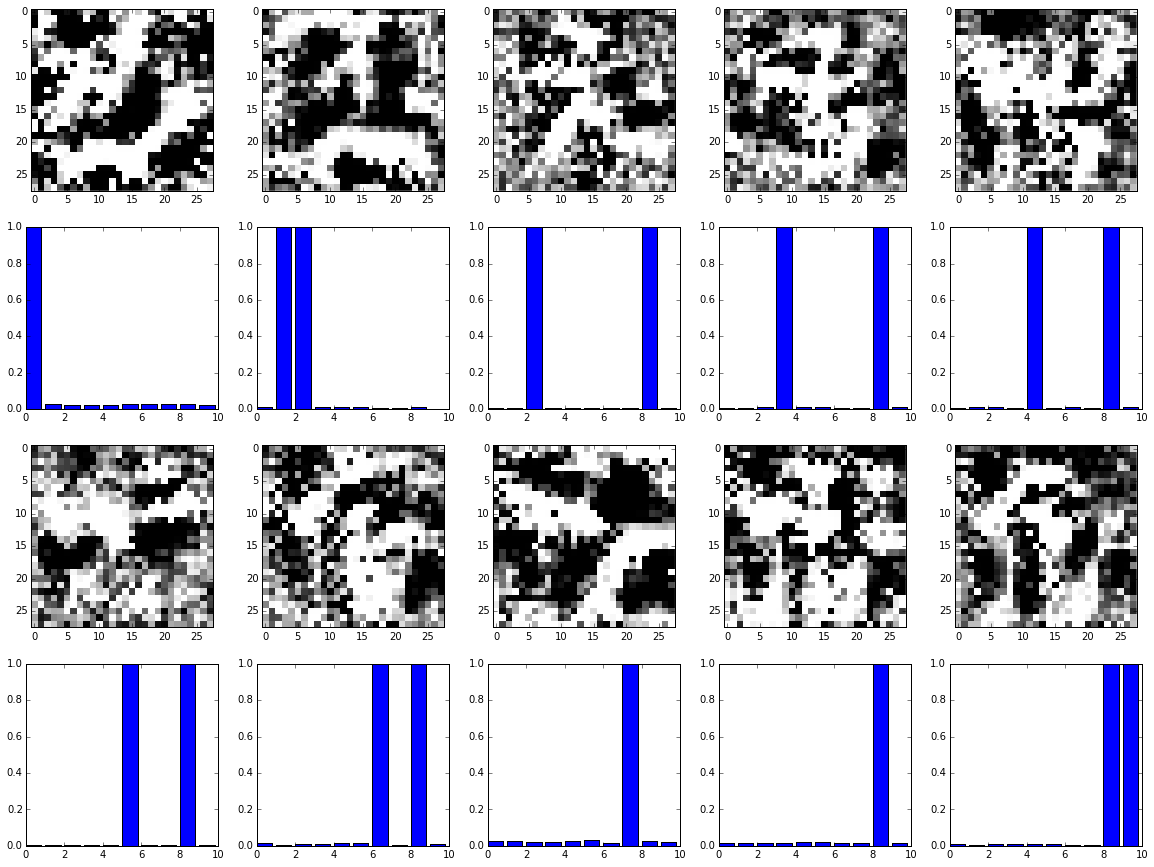

In [756]:
tableau(net,np.random.rand(1,28,28),-1,1,5000)

Distinct images still emerge from the initial noise. Again, we see overlap between predicted labels. Even though 8 was not represented in our initial image, its label occurs in the images for 2, 3, 4, 5, 6, 7, and 9; this suggests that this network is highly susceptible to giving false positives for 8.

---
What if we optimize to avoid specific labels?

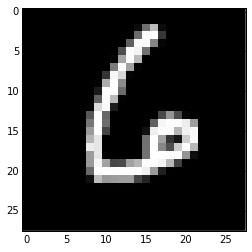

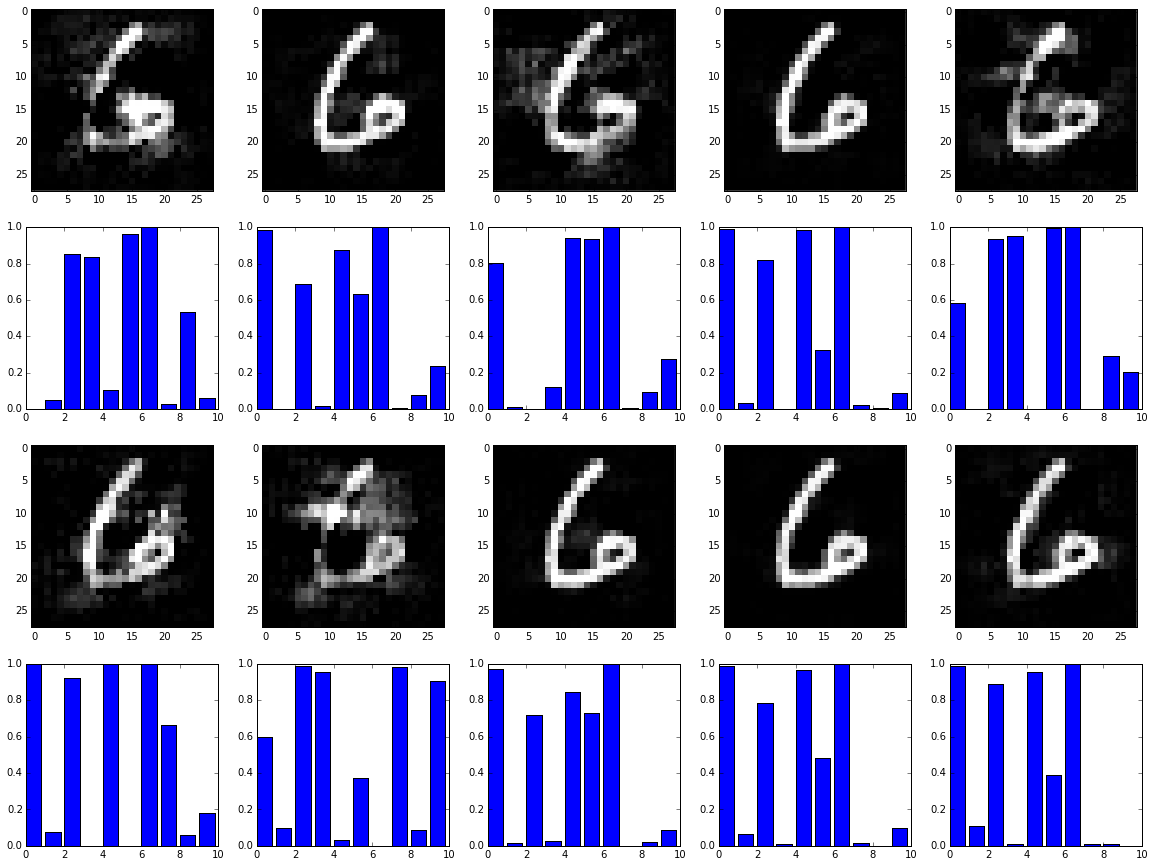

In [772]:
tableau(net,tst_img[2].reshape(1,28,28),0,-1,5000)

Although the original character is still human-readable, this algorithm obscures it enough to fool the classifier. We can think of this as exposing a weakness in the original classifier - clearly, it is not adequate for use with smudged data.

---
Finally, let's try starting from a blank image.

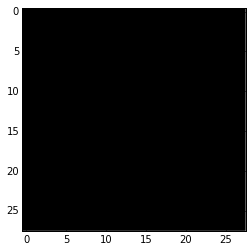

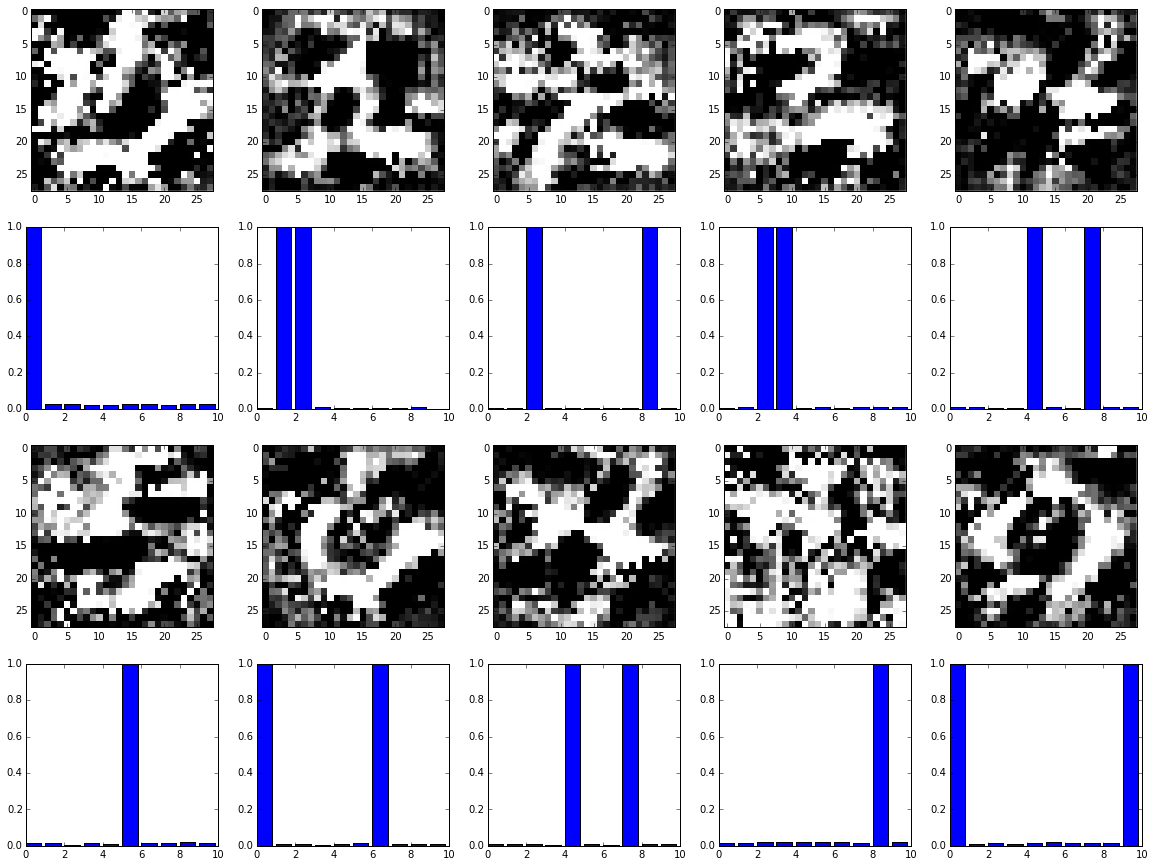

In [766]:
tableau(net,np.zeros([1,28,28]),-1,1,5000)

Clear figures emerge from this method, but they have no visual relation to any of our natural images.

---
This suggests a few topics of interest:
 * Quantifying similarity between label domains
 * Measuring the impactfulness of each pixel on the predicted label
 * Investigating dependence relations between different input features (compare neural networks as logic gates)

---
Now, another stab at the MCMC approach. Instead of starting from noise, we now start from a natural image.

In [776]:
import pymc

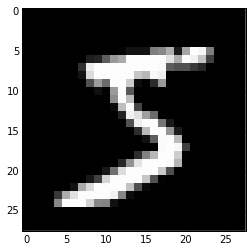

In [779]:
five = trn_img[0].reshape(28,28)
imshow(five)

In [812]:
whichLabel = 2

# Random variable with probability distribution based on a single label class
@pymc.stochastic
def digitImage(value = five):
    
    # Probability function of the current image
    def logp(value):
        
        # Reconstruct image from vector
        img = value.reshape(28,28,1)
        
        # Exclude images with intensities outside of the accepted range
        if np.min(img) < 0.0 or np.max(img) > 1.0:
            return -np.inf;
        else:
            # Preprocess inxzput
            imgBlob = transformer.preprocess(net.inputs[0],img)
            
            # Get prediction strength
            out = net.forward_all(**{net.inputs[0]: imgBlob})
            lbl = out['pred'][0,whichLabel]
            
            # Take log of output
            return -np.log(lbl)

In [813]:
M = pymc.MCMC([digitImage])

In [814]:
# Take 200k samples after an initial 800k burn, recording every 1000th sample
M.sample(100000,80000,100)

 [-----------------100%-----------------] 100000 of 100000 complete in 10.6 sec

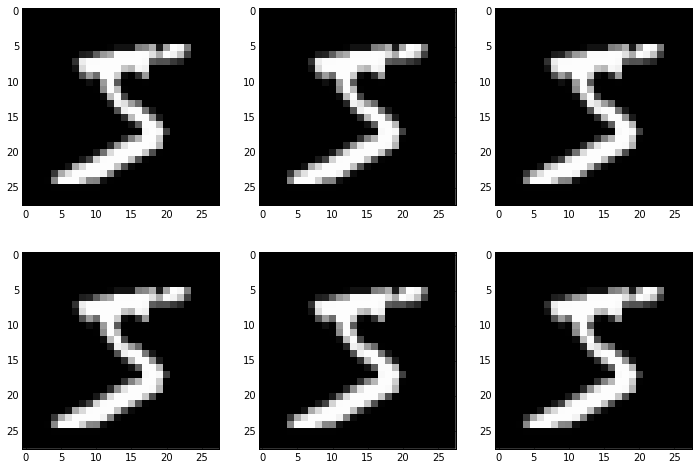

In [815]:
figure(figsize=(12,8))
for i in np.arange(1,7):
    subplot(2,3,i)
    imshow(M.trace('digitImage')[-(i*20)].reshape([28,28]))

It doesn't seem like MCMC is actually producing distinct samples. I'm still doing something wrong here; will have to work on this further.